In [1]:
!pip install statsmodels

In [8]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("data/AirPassengers.zip", index_col='Month', parse_dates=['Month'])

<Axes: xlabel='Month'>

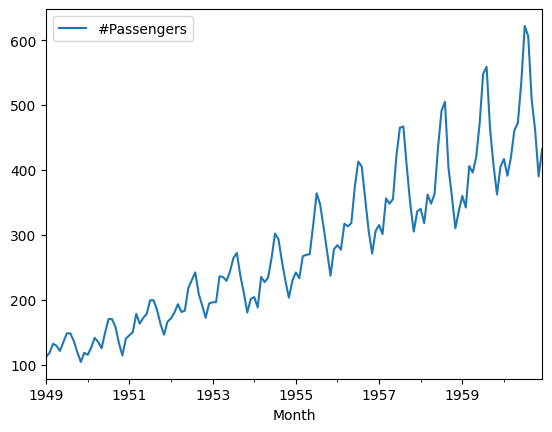

In [4]:
# выведем данные на временной график
df.plot()


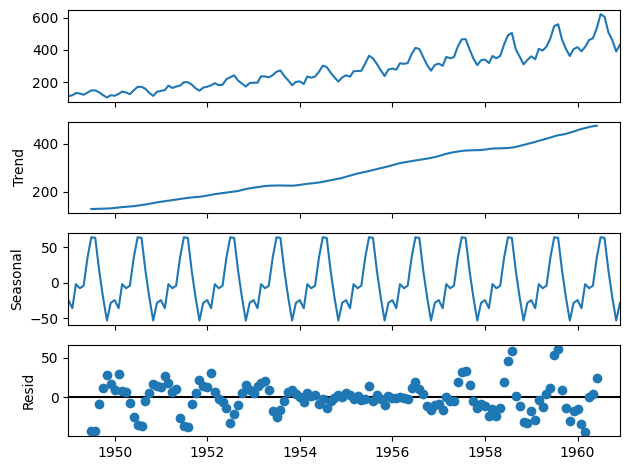

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

In [9]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


In [13]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

[26.66235]


Рассмотрим пример проведения теста Дики — Фуллера на данных временного ряда Daily Total Female Births. В данных содержится количественная информация о девочках, рождённых за несколько месяцев. Для проведения теста будем использовать функцию adfuller() из пакета statsmodels.

In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data\daily-total-female-births.zip", 
    header=0, 
    index_col=0
).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -4.808291253559763
p-value: 5.243412990149865e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Значение статистики меньше всех критических значений: отвергаем нулевую гипотезу (H0), данные являются стационарными (не содержат тренда и сезонности).

### ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Если тест на стационарность показал, что ряд нестационарный и в нём присутствуют тренд и сезонность, необходимо избавиться от них.

Обычно для этого достаточно взять разность рядов. Разность выполняется путём дифференцирования ряда, для этого вычисляется разность между двумя соседними наблюдениями ряда. Если полученная первая разность ряда окажется стационарной, то этот ряд называется интегрированным рядом первого порядка.

Для определения порядка интегрированного ряда необходимо сделать следующее:



In [17]:
# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_1 = df.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -12.625178633871343
p-value:  1.5472400091969784e-23
Critical values:  {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
ряд стационарен


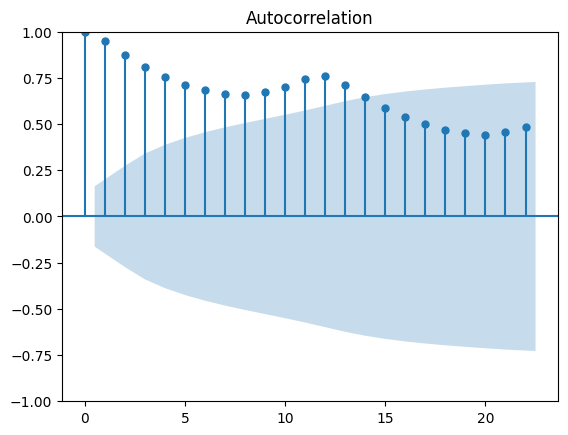

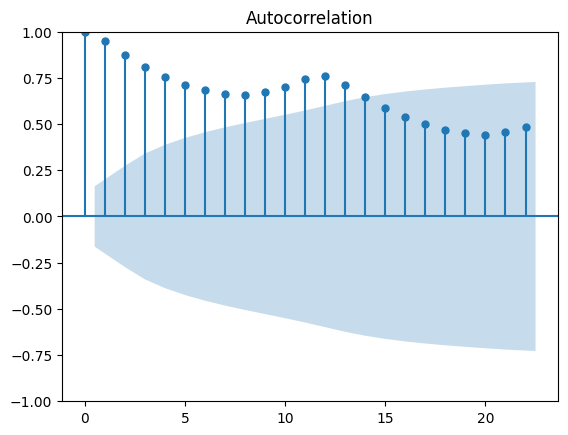

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv("data\AirPassengers.zip", index_col='Month', parse_dates=['Month'])
plot_acf(df)

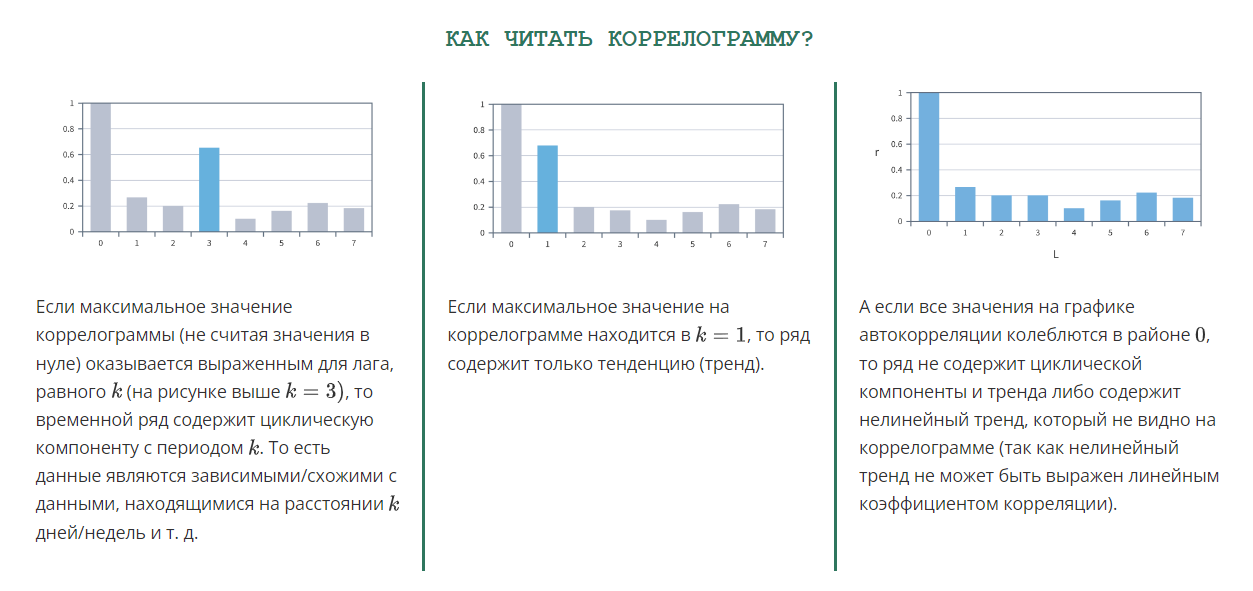

Ниже приведены некоторые из ключевых шагов, которые необходимо выполнить для обучения AR-модели:

- Отобразить временной ряд.
- Проверить ряд на стационарность (модель AR можно применять только к стационарному временному ряду).
- Выбрать параметр p (порядок модели AR).
- Обучить модель.

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, sep=",")

In [21]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

In [22]:
# Инициализируем и обучим модель. Возьмём lags=8 (AR(8)) — на практике же будем определять это значение по графику частичной автокорреляции:

ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Wed, 08 Nov 2023   AIC                          48483.625
Time:                        13:20:59   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

Сделаем предсказание. Метод predict требует два обязательных параметра — метки начала и окончания предсказания. Метка начала предсказания будет равна количеству данных в обучающей выборке, так как нас интересует прогноз со следующего дня. Метка окончания в нашем случае будет равна len(train_data)+100, что эквивалентно len(df)-1, так как len(df) = len(train_data) + len(test_data).

In [23]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
